## Проверка железа

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun  7 12:33:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


#Нейронная сеть для классификации и локализации кошек и собак

Монтируем google drive в colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Подготовка аугментационных данных

###Разделяем данные из исходной папки train на train (90%) и validation (10%)

Подключаем необходимые модули

In [ ]:
import zipfile 
import copy
import os
from glob import glob
import shutil
import numpy as np

Качаем исходный датасет на Colab.

In [ ]:
zip_file = '/content/drive/My Drive/ClassReg/cats_dogs_dataset.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

Создаем соответсвующие каталоги для изображений.

In [ ]:
os.mkdir('/content/drive/My Drive/ClassReg/dataset')

In [ ]:
os.mkdir('/content/drive/My Drive/ClassReg/dataset/train')
os.mkdir('/content/drive/My Drive/ClassReg/dataset/valid')
os.mkdir('/content/drive/My Drive/ClassReg/dataset/test')

Извлекаем случайным образом 10% изображений из исходной папки train в созданные папки train и valid. 

In [ ]:
folder = '/content/cats_dogs_dataset/train/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
indices = list(range(count_images))
np.random.shuffle(indices) # размешиваем индексы для случайного выбора изображений
valid_split = 0.1 # задаем процент изображений для валидации
split = int(np.floor(valid_split * count_images)) 
num_cats = 0
num_dogs = 0
num_valid = 0
num_train = 0

for index in indices:
    img_path = os.path.splitext(img_list_path[index])[0]
    anno_path = img_path + '.txt'
    with open(anno_path, 'r') as f:
        anno = [word for line in f for word in line.split(' ')]
    label = int(anno[0])
    # копируем изображения по папкам и подсчитываем количество изображений каждой из категорий классов
    if num_valid != split and label == 1: 
        shutil.copy(img_list_path[index], '/content/drive/My Drive/ClassReg/dataset/valid')
        shutil.copy(anno_path, '/content/drive/My Drive/ClassReg/dataset/valid')
        num_cats += 1
    elif num_valid != split:
        shutil.copy(img_list_path[index], '/content/drive/My Drive/ClassReg/dataset/valid')
        shutil.copy(anno_path, '/content/drive/My Drive/ClassReg/dataset/valid')
        num_dogs += 1
    else:
        shutil.copy(img_list_path[index], '/content/drive/My Drive/ClassReg/dataset/train')
        shutil.copy(anno_path, '/content/drive/My Drive/ClassReg/dataset/train')
        num_train += 1 
    num_valid = num_cats + num_dogs

print('num all images = ', count_images)
print('num images in valid = ', num_valid)
print('num images in train = ', num_train)
print('num cats in valid = ', num_cats)
print('num dogs in valid = ', num_dogs)

num all images =  2985
num images in valid =  298
num images in train =  2687
num cats in valid =  96
num dogs in valid =  202


Проверка количества скопированных изображений.

In [ ]:
folder = '/content/drive/My Drive/ClassReg/dataset/train/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
print('num images in train = ', count_images)

num images in train =  2687


In [ ]:
folder = '/content/drive/My Drive/ClassReg/dataset/valid/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
print('num images in valid = ', count_images)

num images in train =  298


Копируем изображения из исходной папки valid в папку test.

In [ ]:
folder = '/content/cats_dogs_dataset/valid/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
num_images = 0

for index in range(count_images):
    anno_path = os.path.splitext(img_list_path[index])[0] + '.txt'
    shutil.copy(img_list_path[index], '/content/drive/My Drive/ClassReg/dataset/test')
    shutil.copy(anno_path, '/content/drive/My Drive/ClassReg/dataset/test')
    num_images += 1 

print('num images in valid = ', count_images)
print('num images in test = ', num_images)

num images in valid =  400
num images in test =  400


Проверка количества скопированных изображений.

In [ ]:
folder = '/content/drive/My Drive/ClassReg/dataset/test/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
print('num images in test = ', count_images)

num images in train =  400


Создадим zip архив из новых каталогов с данными.

In [ ]:
shutil.make_archive('/content/drive/My Drive/ClassReg/dataset', 'zip', root_dir='/content/drive/My Drive/ClassReg', base_dir='dataset')

###Расширяем датасет за счет аугментаций

Скачиваем на Colab и подключаем модуль для аугментаций.

In [ ]:
!cp /content/drive/MyDrive/ClassReg/modules/augmentation.py .
from augmentation import add_aug_image

Расширим датасет с помощью применения некоторых аугментаций используя библиотеку imgaug.

In [ ]:
!pip uninstall imgaug && pip uninstall albumentations && pip install git+https://github.com/aleju/imgaug.git

import imgaug.augmenters as iaa

Создаем директорию для аугментированных изображений.

In [ ]:
import os
os.mkdir('/content/augmentation')

Скачиваем датасет.

In [ ]:
import zipfile 
zip_file = '/content/drive/My Drive/ClassReg/dataset.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

Задаем список аугментаций изображений рекомендованный в документации imgaug под названием "A simple and common augmentation sequence".

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

In [ ]:
from glob import glob

folder = '/content/dataset/train/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
print('num images = ', count_images)

save_path = '/content/augmentation/' # путь к папке для сохранения преобразованных изображений
num_iter = 3 # задаем кратное количество преобразованных изображений 
for iter in range(num_iter):
    for i in range(count_images):
        add_aug_image(img_list_path, save_path, seq, i, iter)         

num images =  2687


Проверка количества созданных аугментированных изображений.

In [ ]:
folder = '/content/augmentation/'
img_list_path = glob(folder+'/*.jpg')
count_images = len(img_list_path)
print('num images in augmentation = ', count_images)

num images in augmentation =  8061


Создаем архив с аугментированными изображениями.

In [ ]:
import shutil
shutil.make_archive('/content/augmentation', 'zip', root_dir='/content', base_dir='augmentation')

'/content/augmentation.zip'

Скачиваем архив на google drive.

In [ ]:
shutil.copy('/content/augmentation.zip', '/content/drive/My Drive/ClassReg')

'/content/drive/My Drive/Neurus/augmentation.zip'

## Скачиваем данные и модули из google drive в colab 

In [ ]:
import zipfile 

In [ ]:
zip_file = '/content/drive/My Drive/ClassReg/dataset.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

In [ ]:
zip_file = '/content/drive/My Drive/ClassReg/augmentation.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

In [ ]:
!cp /content/drive/MyDrive/ClassReg/modules/ForDataset.py .
!cp /content/drive/MyDrive/ClassReg/modules/metrics.py .
!cp /content/drive/MyDrive/ClassReg/modules/TrainValidTest.py .
!cp /content/drive/MyDrive/ClassReg/modules/MyLinearLayer.py .
!cp /content/drive/MyDrive/ClassReg/modules/visualization.py .

## Подключение необходимых модулей

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models

import copy
import os
from glob import glob
import shutil

import ForDataset as ds
from visualization import draw_bb 
from MyLinearLayer import Linear2out
import TrainValidTest as tr 

In [ ]:
device = torch.device("cuda:0") # Use GPU 

##Вычисляем значения среднего и стандартного отклонения на нашем тренировочном датасете, чтобы провести нормализацию входных данных.

Cкачиваем исходный датасет на Colab.

In [ ]:
import zipfile
zip_file = '/content/drive/My Drive/ClassReg/cats_dogs_dataset.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора.
Создаем датасет (на основе тренировочных данных) и стандартный загрузчик PyTorch. Вычисляем среднее и стандартное отклонение, которые используются в классе Normalize, находящимся в модуле ForDataset.

In [ ]:
tfms_n = transforms.Compose([ds.Resize((224,224)), ds.ToTensor()])
dataset = ds.CustomDataset('/content/cats_dogs_dataset/train/', transform=tfms_n)
loader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=False)

# вычисляем среднее
mean = 0.0
for data in loader:
    images = data['image'] 
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

# вычисляем стандартное отклонение
var = 0.0
for data in loader:
    images = data['image']
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))

In [ ]:
print('mean =', mean)
print('std =', std)

mean = tensor([0.4737, 0.4421, 0.3916], dtype=torch.float64)
std = tensor([0.2639, 0.2587, 0.2665], dtype=torch.float64)


## Подготавливаем датасет

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения).

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])

Создаем тренировочный и валидационный датасеты.

In [ ]:
data_train = ds.CustomDataset('/content/dataset/train/','/content/augmentation/', transform=tfms)
data_valid = ds.CustomDataset('/content/dataset/valid/', transform=tfms)

Определяем размер батча и создаем стандартные загрузчики данных PyTorch.

In [ ]:
batch_size = 64 # задаем размер входного батча 

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,    # используем стандартный загрузчик PyTorch  
                                           shuffle=True, num_workers=1)          # с возможностью случайного распределения изображений по батчам 
val_loader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Выведем размеры тренировочного и валидационного датасетов.

In [ ]:
print('Num train images =', len(data_train))
print('Num valid images =', len(data_valid))

Num train images = 10748
Num valid images = 298


##Визуализируем примеры из датасета.

Задаем трансформацию для входных изображений, а именно: изменение размера.
Создаем датасет.

In [ ]:
tfms_v = transforms.Compose([ds.Resize_Visual((224,224))])
data_v = ds.CustomDataset('/content/dataset/train/', '/content/augmentation/', transform=tfms_v)

Визуализируем изображения и информацию о них. Также визуализируем bounding box для каждого изображения используя фунцию draw_bb из модуля vizualization.

№ 2988   image shape: (224, 224, 3)   label: dog   bb coords: [-53 -38 196  89]
№ 9068   image shape: (224, 224, 3)   label: cat   bb coords: [ 68 -33 161  90]
№ 4002   image shape: (224, 224, 3)   label: dog   bb coords: [ 55  20 229 190]
№ 7104   image shape: (224, 224, 3)   label: cat   bb coords: [ 72 -33 223 162]
№ 9001   image shape: (224, 224, 3)   label: cat   bb coords: [ 76  14 204 125]


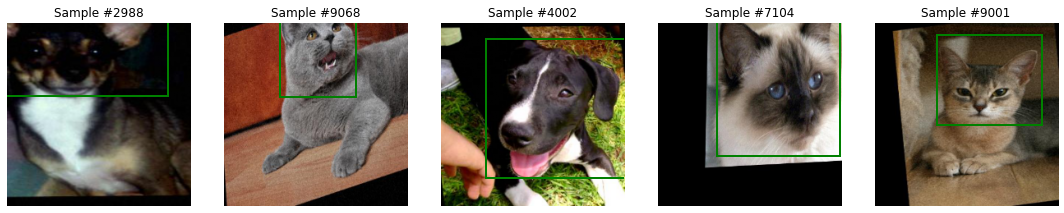

In [ ]:
count_imgs = 5 # задаем количество выводимых изображений

indices = list(range(len(data_v)))
np.random.shuffle(indices) # задаем случайный выбор изображений
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    sample = data_v[i]      
    if sample['label'] == 0: label = 'cat'
    else: label = 'dog'      
    print('№', i, '  image shape:', sample['image'].shape, '  label:', label, '  bb coords:', sample['bb_coords'])   
    ax = plt.subplot(1, count_imgs, count + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    draw_bb(sample['image'], sample['bb_coords']) # функция для рисования bounding box
    count += 1

    if count == count_imgs:
        plt.show()
        break

# Способ 1 - создаем собственную сеть 

##Тренировка

Создадим простую сеть с тремя сверточными слоями по 32, 64 и 128 нейронов и одним полносвязным слоем, который будет выдавать предсказания. Для лучшей сходимости добавим слои с нормализацией батчей входных изображений. 
Также в данной ячейке определим функции потерь, метод оптимизации и метод корректировки коэффициента обучения. 

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
       
            nn.Flatten(),
            Linear2out(128*7*7, 2, 4) # модифицированный линейный слой с 2 выходами для классификации                       
          )                           # и 4 выходами для координат bounding box

nn_model.type(torch.cuda.FloatTensor) # задаем модель в cuda
nn_model.to(device) #загружаем модель на GPU

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-2) # определяем метод оптимизации параметров сети
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, threshold=0.01) # используем learning rate anneling на плато

Задаем количество эпох обучения. Вызываем функцию обучения train_model из модуля TrainValidTest. В результате будет сохранен файл .pth с лучшими параметрами сети, настроенными при обучении. 

In [ ]:
num_epochs = 30

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(nn_model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'aug_best_my_model.pth', path_save_model, scheduler=scheduler)

Ep: 1 ==> Train loss: 1.703302, Val loss: 0.644403, Train accuracy: 0.6618, Val accuracy: 0.6812, Train miou: 0.2277, Val miou: 0.2093, lr: 1.0e-03, time: 0.71 ms
Ep: 2 ==> Train loss: 0.655812, Val loss: 0.611863, Train accuracy: 0.6785, Val accuracy: 0.6779, Train miou: 0.2741, Val miou: 0.2627, lr: 1.0e-03, time: 0.71 ms
Ep: 3 ==> Train loss: 0.633801, Val loss: 0.669813, Train accuracy: 0.6923, Val accuracy: 0.7081, Train miou: 0.2821, Val miou: 0.2780, lr: 1.0e-03, time: 0.73 ms
Ep: 4 ==> Train loss: 0.603137, Val loss: 0.581125, Train accuracy: 0.7033, Val accuracy: 0.7114, Train miou: 0.2828, Val miou: 0.2744, lr: 1.0e-03, time: 0.74 ms
Ep: 5 ==> Train loss: 0.575414, Val loss: 0.642992, Train accuracy: 0.7213, Val accuracy: 0.7215, Train miou: 0.2912, Val miou: 0.2911, lr: 1.0e-03, time: 0.71 ms
Ep: 6 ==> Train loss: 0.562516, Val loss: 1.008349, Train accuracy: 0.7346, Val accuracy: 0.6946, Train miou: 0.2863, Val miou: 0.2654, lr: 1.0e-03, time: 0.73 ms
Ep: 7 ==> Train loss: 

Выводим графики зависимости функции потерь, точности и miou на тренировочных данных (голубая кривая) и валидационных данных (оранжевая кривая) от эпохи обучения.

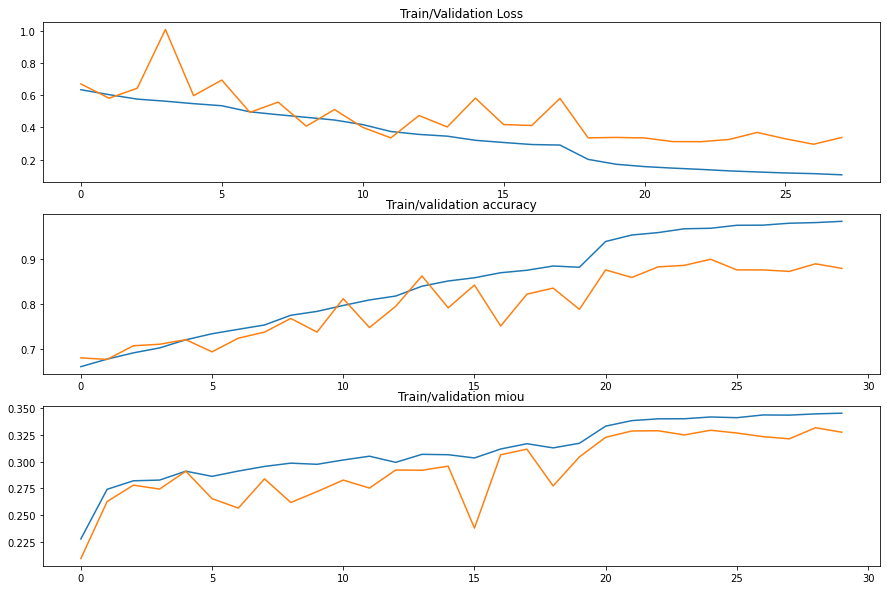

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.title("Train/Validation Loss")
plt.plot(train_loss_history[2:])
plt.plot(val_loss_history[2:])
plt.subplot(312)
plt.title("Train/validation accuracy")
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.subplot(313)
plt.title("Train/validation miou")
plt.plot(train_miou_history)
plt.plot(val_miou_history)

## Испытаем обученную модель на тестовых данных

Определяем архитектуру обученной модели. 

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
       
            nn.Flatten(),
            Linear2out(128*7*7, 2, 4)                     
          )

Загружаем параметры обученной модели.

In [ ]:
load_model = nn_model
load_model.load_state_dict(torch.load('/content/drive/My Drive/ClassReg/best_models_save/aug_best_my_model.pth')) 
load_model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear2out(
    (LinearClass): Linear(in_features=6272, out_features=2, bias=True)
    (LinearIn): Linear(in_features=6272, out_feat

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения). Создаем тестовый датасет и стандартный загрузчик PyTorch.

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])
data_test = ds.CustomDataset('/content/dataset/test/', transform=tfms)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=1)

Проверяем обученную модель на тестовых данных используя функцию test_model из модуля TrainValidTest. В результате будет выведена точность классификации изображений и метрика локализации bounding box.  

In [ ]:
test_accuracy, test_miou, test_labels, test_bb_coords, test_iou_all = tr.test_model(load_model, test_loader)

print('Test accuracy = %4f, Test miou = %4f' % (test_accuracy, test_miou))

Test accuracy = 0.900000, Test miou = 0.340241


Зададим трансформацию разрешения изображений и создадим датасет для визулизации некоторых изображений.

In [ ]:
tfms_v_t = transforms.Compose([ds.Resize_Visual((224,224))])
data_v_t = ds.CustomDataset('/content/dataset/test/', transform=tfms_v_t)

Визуализируем некоторые картинки, с истинными и предсказанными метками классов и bounding boxes (зеленые - заданные, красные - предсказанные).

№ 398   label: cat   predict label: cat   iou: 0.7136674
№ 255   label: dog   predict label: dog   iou: 0.5881309
№ 352   label: cat   predict label: cat   iou: 0.5261205
№ 226   label: dog   predict label: dog   iou: 0.5551475
№ 238   label: dog   predict label: dog   iou: 0.6373262


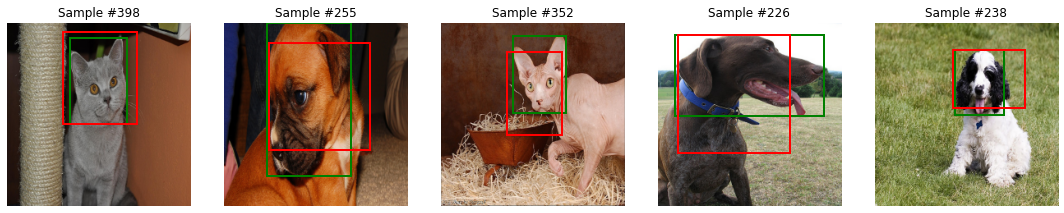

In [ ]:
count_imgs = 5 # количество выводимых изображений
threshold = 0.5 # уровень качества предсказанной метрики iou (больше, либо равен)

indices = list(range(len(test_bb_coords)))
np.random.shuffle(indices)
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    if test_iou_all[i] >= threshold: 
        sample = data_v_t[i]

        if sample['label'] == 0: label = 'cat'
        else: label = 'dog'
        if test_labels[i] == 0: pr_label = 'cat'
        else: pr_label = 'dog'  
        # выведем истинные и предсказанные метки изображения и метрику iou
        print('№', i, '  label:', label, '  predict label:', pr_label, '  iou:', test_iou_all[i].cpu().numpy())        

        ax = plt.subplot(1, count_imgs, count + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')              
        draw_bb(sample['image'], sample['bb_coords'], testing=False) # рисуем истинный bounding box

        t_c = copy.deepcopy(test_bb_coords[i])
        hw = sample['param_img']
        t_c[0::2] = t_c[0::2] * hw[1] # переводим относительные координаты bounding box к пиксельному
        t_c[1::2] = t_c[1::2] * hw[0] # представлению используя сохраненные размеры исходного изображения
        t_c = t_c.astype(int)
        draw_bb(sample['image'], t_c, testing=True) # рисуем предсказанный bounding box
        count += 1 

    if count == count_imgs: break      

# Способ 2 - transfer learning

##Тренировка

Попробуем для классификации использовать предобученную модель, например resnet18. Она обучена на датасете ImageNet.
Сначала попробуем заменить последний слой на новый и обучить только его, при этом, заморозив все остальные. 

In [ ]:
model = models.resnet18(pretrained=True) # загружаем натренированную модель

for param in model.parameters(): # замораживаем слои
    param.requires_grad = False
num_ftrs = model.fc.in_features

model.fc = Linear2out(num_ftrs, 2, 4) # заменяем последний слой
model = model.to(device)

num_epochs = 20 # задаем количество эпох обучения

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(model.fc.parameters(), lr=1e-2) # определяем метод оптимизации параметров сети
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=0.001) # используем learning rate anneling на плато

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'aug_best_resnet18_freeze.pth', path_save_model, scheduler=scheduler)

Ep: 1 ==> Train loss: 2.132023, Val loss: 0.077125, Train accuracy: 0.9409, Val accuracy: 0.9732, Train miou: 0.2424, Val miou: 0.3165, lr: 1.0e-02, time: 1.17 ms
Ep: 2 ==> Train loss: 0.083184, Val loss: 0.066958, Train accuracy: 0.9743, Val accuracy: 0.9899, Train miou: 0.2862, Val miou: 0.3125, lr: 1.0e-02, time: 1.16 ms
Ep: 3 ==> Train loss: 0.075215, Val loss: 0.059537, Train accuracy: 0.9787, Val accuracy: 0.9799, Train miou: 0.2943, Val miou: 0.3227, lr: 1.0e-02, time: 1.17 ms
Ep: 4 ==> Train loss: 0.078297, Val loss: 0.064562, Train accuracy: 0.9767, Val accuracy: 0.9899, Train miou: 0.2961, Val miou: 0.3160, lr: 1.0e-02, time: 1.17 ms
Ep: 5 ==> Train loss: 0.080987, Val loss: 0.145352, Train accuracy: 0.9755, Val accuracy: 0.9631, Train miou: 0.3019, Val miou: 0.2062, lr: 1.0e-02, time: 1.17 ms
Ep: 6 ==> Train loss: 0.098810, Val loss: 0.065084, Train accuracy: 0.9733, Val accuracy: 0.9799, Train miou: 0.2968, Val miou: 0.2352, lr: 1.0e-02, time: 1.17 ms
Ep: 7 ==> Train loss: 

Как мы видим, нам не удалось преодолеть miou на валидации выше 32,9%. 
Попробуем другой вариант, также заменим последний слой, но при этом будем тренировать всю модель.

In [ ]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = Linear2out(num_ftrs, 2, 4) # заменяем последний слой
model = model.to(device)

num_epochs = 30 # задаем количество эпох обучения

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2) # определяем метод оптимизации параметров сети 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=0.001) # используем learning rate anneling на плато

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'aug_best_resnet18.pth', path_save_model, scheduler=scheduler)

Ep: 1 ==> Train loss: 0.116261, Val loss: 0.041289, Train accuracy: 0.9566, Val accuracy: 0.9933, Train miou: 0.3060, Val miou: 0.3240, lr: 1.0e-04, time: 1.10 ms
Ep: 2 ==> Train loss: 0.022441, Val loss: 0.072508, Train accuracy: 0.9954, Val accuracy: 0.9732, Train miou: 0.4331, Val miou: 0.3713, lr: 1.0e-04, time: 1.17 ms
Ep: 3 ==> Train loss: 0.027850, Val loss: 0.050654, Train accuracy: 0.9929, Val accuracy: 0.9799, Train miou: 0.4562, Val miou: 0.4139, lr: 1.0e-04, time: 1.17 ms
Ep: 4 ==> Train loss: 0.028439, Val loss: 0.084270, Train accuracy: 0.9920, Val accuracy: 0.9765, Train miou: 0.4645, Val miou: 0.3623, lr: 1.0e-04, time: 1.11 ms
Ep: 5 ==> Train loss: 0.034375, Val loss: 0.047594, Train accuracy: 0.9916, Val accuracy: 0.9866, Train miou: 0.4677, Val miou: 0.4465, lr: 1.0e-04, time: 1.09 ms
Ep: 6 ==> Train loss: 0.012451, Val loss: 0.030000, Train accuracy: 0.9980, Val accuracy: 0.9899, Train miou: 0.5137, Val miou: 0.5010, lr: 1.0e-05, time: 1.15 ms
Ep: 7 ==> Train loss: 

Выводим графики зависимости функции потерь, точности и miou на тренировочных данных (голубая кривая) и валидационных данных (оранжевая кривая) от эпохи обучения.

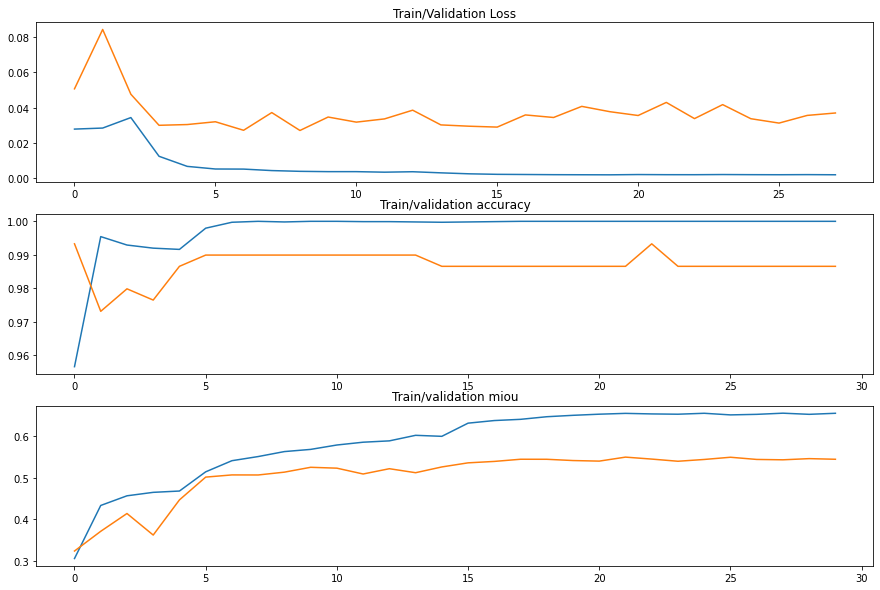

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.title("Train/Validation Loss")
plt.plot(train_loss_history[2:])
plt.plot(val_loss_history[2:])
plt.subplot(312)
plt.title("Train/validation accuracy")
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.subplot(313)
plt.title("Train/validation miou")
plt.plot(train_miou_history)
plt.plot(val_miou_history)

## Испытаем обученную модель на тестовых данных

Загружаем параметры обученной модели.

In [ ]:
load_model = models.resnet18(pretrained=True)

num_ftrs = load_model.fc.in_features
load_model.fc = Linear2out(num_ftrs, 2, 4)
load_model = load_model.to(device)

load_model.load_state_dict(torch.load('/content/drive/My Drive/ClassReg/best_models_save/aug_best_resnet18.pth')) 
load_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения). Создаем тестовый датасет и стандартный загрузчик PyTorch.

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])
data_test = ds.CustomDataset('/content/dataset/test/', transform=tfms)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=1)

Проверяем обученную модель на тестовых данных используя функцию test_model из модуля TrainValidTest. В результате будет выведена точность классификации изображений и метрика локализации bounding box.

In [ ]:
test_accuracy, test_miou, test_labels, test_bb_coords, test_iou_all = tr.test_model(load_model, test_loader)

print('Test accuracy = %4f, Test miou = %4f' % (test_accuracy, test_miou))

Test accuracy = 0.990000, Test miou = 0.592295


Зададим трансформацию разрешения изображений и создадим датасет для визулизации некоторых изображений.

In [ ]:
tfms_v_t = transforms.Compose([ds.Resize_Visual((224,224))])
data_v_t = ds.CustomDataset('/content/dataset/test/', transform=tfms_v_t)

Визуализируем некоторые картинки, с истинными и предсказанными метками классов и bounding boxes (зеленые - заданные, красные - предсказанные).

№ 165   label: dog   predict label: dog   iou: 0.50998056
№ 147   label: cat   predict label: cat   iou: 0.63544315
№ 226   label: dog   predict label: dog   iou: 0.6760611
№ 45   label: dog   predict label: dog   iou: 0.70523
№ 50   label: dog   predict label: dog   iou: 0.7247001


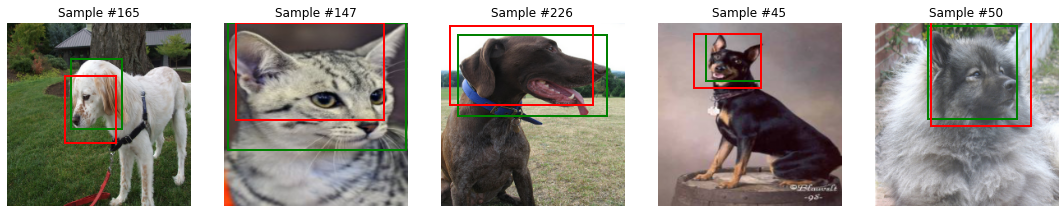

In [ ]:
count_imgs = 5 # количество выводимых изображений
threshold = 0.5 # уровень качества предсказанной метрики iou (больше, либо равен)

indices = list(range(len(test_bb_coords)))
np.random.shuffle(indices)
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    if test_iou_all[i] >= threshold: 
        sample = data_v_t[i]

        if sample['label'] == 0: label = 'cat'
        else: label = 'dog'
        if test_labels[i] == 0: pr_label = 'cat'
        else: pr_label = 'dog'  
        # выведем истинные и предсказанные метки изображения и метрику iou
        print('№', i, '  label:', label, '  predict label:', pr_label, '  iou:', test_iou_all[i].cpu().numpy())        

        ax = plt.subplot(1, count_imgs, count + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')              
        draw_bb(sample['image'], sample['bb_coords'], testing=False) # рисуем истинный bounding box

        t_c = copy.deepcopy(test_bb_coords[i])
        hw = sample['param_img']
        t_c[0::2] = t_c[0::2] * hw[1] # переводим относительные координаты bounding box к пиксельному
        t_c[1::2] = t_c[1::2] * hw[0] # представлению используя сохраненные размеры исходного изображения
        t_c = t_c.astype(int)
        draw_bb(sample['image'], t_c, testing=True) # рисуем предсказанный bounding box
        count += 1 

    if count == count_imgs: break  